# Objective

This example implements a modern attention-free, gMLP  based model for image classification, demonstrated on the CIFAR-100 dataset:

# Installation of Packages

In [1]:
# !pip install -q tensorflow_datasets
# !pip install datasets
# !pip install keras_cv
# !pip install keras_hub

# Download Dataset from external source

# Importing packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import applications
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.datasets import cifar100
from tensorflow import keras

# from tensorflow.keras.datasets import mnist
# import tensorflow_datasets as tfds
# from keras.applications import EfficientNetB0
# import keras_cv
# import keras_hub

# Custom Functions

# Reading Data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


# Data Inspection / Visualization

In [4]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [5]:
numRows = x_train.shape[0]
numRows

50000

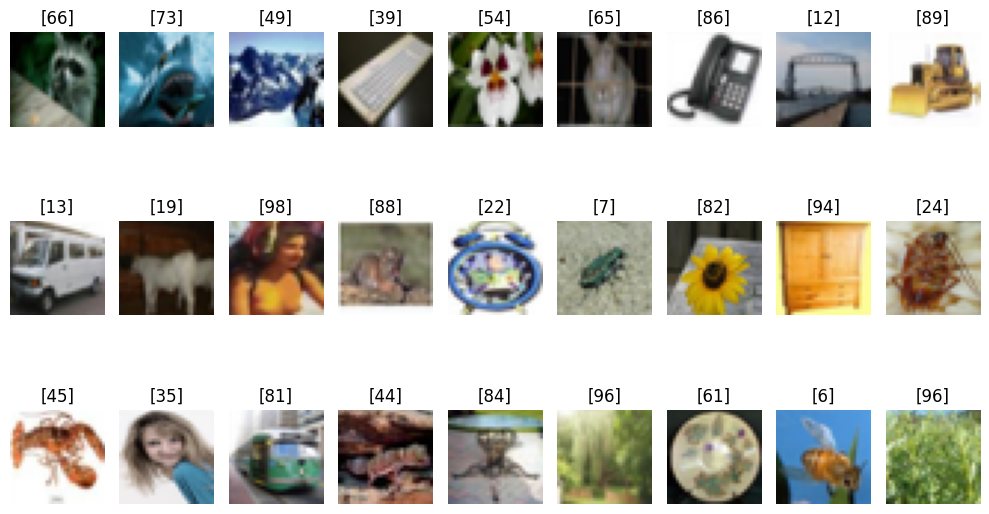

In [6]:
plt.figure(figsize=(10,8))
randomIndex = np.random.randint(0, numRows, 27)
for i in range(27):
    plt.subplot(4, 9, i+1)
    item = x_train[int(randomIndex[i])]
    plt.imshow(item)
    plt.title(y_train[int(randomIndex[i])])
    plt.axis(False)


plt.tight_layout()

# Data Preprocessing

In [7]:
num_classes = len(np.unique(y_train)) 
input_shape = (32, 32, 3)
num_classes

100

In [8]:
weight_decay = 0.0001
batch_size = 128
num_epochs = 20   
dropout_rate = 0.2
image_size = 64   
patch_size = 8   
num_patches = (image_size // patch_size) ** 2  # (64 / 8)^2 = 64 
embedding_dim = 256  
num_blocks = 4  

In [9]:
print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


# Data Postprocessing

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        patches = ops.image.extract_patches(x, self.patch_size)
        batch_size = ops.shape(patches)[0]
        num_patches = ops.shape(patches)[1] * keras.ops.shape(patches)[2]
        patch_dim = ops.shape(patches)[3]
        out = ops.reshape(patches, (batch_size, num_patches, patch_dim))
        return out

In [11]:
class PositionEmbedding(layers.Layer):
    def __init__(
        self,
        sequence_length,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.initializer = initializers.get(initializer)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "initializer": initializers.serialize(self.initializer),
            }
        )
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="embeddings",
            shape=[self.sequence_length, feature_size],
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs, start_index=0):
        shape = ops.shape(inputs)
        feature_length = shape[-1]
        sequence_length = shape[-2]
        # trim to match the length of the input sequence, which might be less
        # than the sequence_length of the layer.
        position_embeddings = ops.convert_to_tensor(self.position_embeddings)
        position_embeddings = ops.slice(
            position_embeddings,
            (start_index, 0),
            (sequence_length, feature_length),
        )
        return ops.broadcast_to(position_embeddings, shape)

    def compute_output_shape(self, input_shape):
        return input_shape

In [12]:
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.channel_projection1 = models.Sequential(
            [
                layers.Dense(units=embedding_dim * 2, activation="gelu"),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        
        u, v = keras.ops.split(x, indices_or_sections=2, axis=2)
        v = self.normalize2(v)
        
        v_channels = keras.ops.transpose(v, axes=(0, 2, 1))
        v_projected = self.spatial_projection(v_channels)
        v_projected = keras.ops.transpose(v_projected, axes=(0, 2, 1))
        
        return u * v_projected

    def call(self, inputs):
        
        x = self.normalize1(inputs)
        
        x_projected = self.channel_projection1(x)
        
        x_spatial = self.spatial_gating_unit(x_projected)
        
        x_projected = self.channel_projection2(x_spatial)
        
        return x + x_projected

# Model

In [13]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
     
    augmented = data_augmentation(inputs)
    
    patches = Patches(patch_size)(augmented)
    
    x = layers.Dense(units=embedding_dim)(patches)
    
    if positional_encoding:
        x = x + PositionEmbedding(sequence_length=num_patches)(x)
    
    x = blocks(x)
   
    representation = layers.GlobalAveragePooling1D()(x)
    
    representation = layers.Dropout(rate=dropout_rate)(representation)
    
    logits = layers.Dense(num_classes)(representation)
    
    return models.Model(inputs=inputs, outputs=logits)

In [14]:
def run_experiment(model):
    
    optimizer = optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay,
    )
     
    model.compile(
        optimizer=optimizer,
        loss= losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            metrics.SparseCategoricalAccuracy(name="acc"),
            metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    
    early_stopping = callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
        verbose=0,
    )

    evaluation = model.evaluate(x_test, y_test)
   

     
    return history, evaluation, model

# Compile

In [15]:
data_augmentation = models.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
 
data_augmentation.layers[0].adapt(x_train)

In [16]:
gmlp_blocks = models.Sequential(
    [gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)
history, evaluation, mymodel  = run_experiment(gmlp_classifier)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.4395 - loss: 2.2119 - top5-acc: 0.7437


# Evaluation

In [17]:
_, accuracy, top_5_accuracy = evaluation
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

Test accuracy: 43.74%
Test top 5 accuracy: 74.03%


In [18]:
true_labels = np.concatenate([x for x in y_test], axis=0)
predictions  = np.argmax(mymodel.predict(x_test), axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [19]:
def make_plot(metric):
  plt.plot(history.history[metric ])
  plt.plot(history.history['val_'+metric ])
  plt.title( 'Model '+metric )
  plt.ylabel( metric.capitalize() )
  plt.xlabel( 'Epoch' )
  plt.legend([ 'Train' , 'Validation' ], loc='upper left' )
  plt.show()

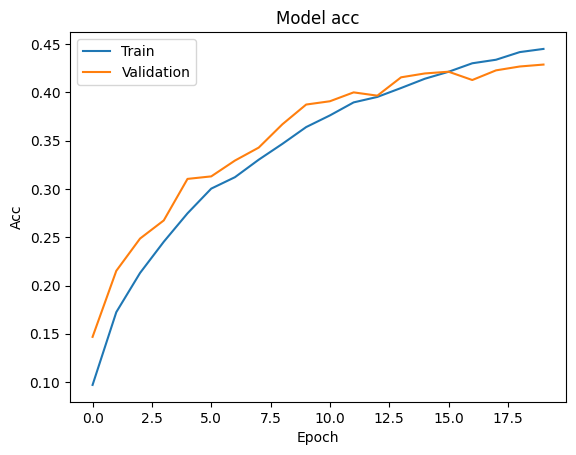

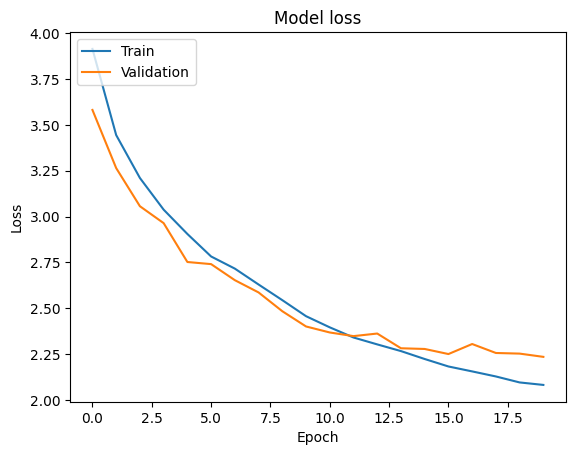

In [20]:
make_plot('acc')
make_plot('loss')

# Inference

# Deploy

In [21]:
#model.save("custom_image_classification_model")